# 🌎 Welcome to the CSE151B Spring 2025 Climate Emulation Competition!

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help you:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


### 📦 Install Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [ ]:
!pip install xarray zarr dask lightning matplotlib wandb cftime einops --quiet
#!pip install packaging==23.2 --force-reinstall --quiet

import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
import torch.nn.functional as F

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.4/205.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



SyntaxError: invalid syntax (2972970889.py, line 1)

In [ ]:
config = {
    "data": {
        "path": "climate_data/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "context_months": 1,
        "batch_size": 64,
        "num_workers": 8,
    },
    "model": {
        "type": "unet_temporal",
        "init_dim": 64,
        "depth": 4,
        "dropout_rate": 0.1,
    },
    "training": {
        "lr": 1e-3,
    },
    "trainer": {
        "max_epochs": 30,
        "accelerator": "gpu",
        "devices": "1",
        "precision": "16-mixed",
        "deterministic": False,
        "num_sanity_val_steps": 0,
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])

In [ ]:
os.environ['PATH'] += ':/home/miseo/.local/bin'

In [ ]:
!kaggle competitions download -c cse151b-spring2025-competition


100%|████████████████████████████████████████▉| 351M/351M [00:01<00:00, 327MB/s]
100%|█████████████████████████████████████████| 351M/351M [00:01<00:00, 325MB/s]


In [ ]:
!unzip -q cse151b-spring2025-competition.zip -d climate_data

replace climate_data/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr/.zattrs? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
!ls climate_data

### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [ ]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline(Changed to Temporal U-net)

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**.

We encourage you to build and experiment with your own models and ideas.


In [ ]:
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)

class UNetTemporal(nn.Module):
    def __init__(self, in_channels, out_channels, init_dim=64, depth=4):
        super().__init__()
        self.depth = depth
        self.input_proj = nn.Conv2d(in_channels, init_dim, kernel_size=1)  # NEW
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        chs = [init_dim * 2**i for i in range(depth)]

        for i in range(depth):
            self.downs.append(UNetBlock(init_dim if i == 0 else chs[i-1], chs[i]))
        self.pool = nn.MaxPool2d(2)

        for i in range(depth-1, 0, -1):
            self.ups.append(nn.ConvTranspose2d(chs[i], chs[i-1], 2, stride=2))
            self.ups.append(UNetBlock(chs[i-1] * 2, chs[i-1]))

        self.out_conv = nn.Conv2d(chs[0], out_channels, kernel_size=1)

    def forward(self, x):
        x = x.mean(dim=1)  # Temporal average → (B, C, H, W)
        x = self.input_proj(x)  # Project to init_dim

        encs = []
        for down in self.downs:
            x = down(x)
            encs.append(x)
            x = self.pool(x)

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip = encs[-(i//2 + 2)] if i != len(self.ups) - 2 else encs[0]  # safe indexing
            if x.shape[2:] != skip.shape[2:]:
                x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, skip], dim=1)
            x = self.ups[i+1](x)

        return self.out_conv(x)


### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [ ]:
class Normalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std
        print("✔ Output mean:", self.mean_out.flatten())
        print("✔ Output std:", self.std_out.flatten())

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        return data * self.std_out + self.mean_out


### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


In [ ]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()
        self.output_is_normalized = output_is_normalized


        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

        print("Final dataset input shape:", self.inputs.shape)
        print("Final dataset output shape:", self.outputs.shape)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        x = self.inputs[idx]          # (T, C, H, W)
        y = self.outputs[idx]         # (C, H, W)
        return x, y

class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        val_split=0.1,
        test_months=360,
        batch_size=32,
        num_workers=8,
        seed=42,
        context_months=1
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.context_months = context_months
        self.normalizer = Normalizer()



    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            print(f"\n📦 Loading SSP: {ssp}")
            print(f"✅ Expected input vars: {self.input_vars}")
            print(f"✅ Expected output vars: {self.output_vars}")

            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")

                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp, member_id=self.target_member_id)
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})

                output_dask.append(da_out.data)

            if len(output_dask) != len(self.output_vars):
                raise ValueError(f"❌ Expected {len(self.output_vars)} output variables, but got {len(output_dask)}")


            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)


        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            print("Available SSPs in dataset:", ds["ssp"].values)
            print("Available member_ids:", ds["tas"].sel(ssp="ssp245").coords["member_id"].values)
            x, y = load_ssp(ssp)

            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )
        print("Mean out:", self.normalizer.mean_out)
        print("Std out:", self.normalizer.std_out)

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        def to_sequences(x, seq_len):
            total = x.shape[0]
            return da.stack([x[i:total - seq_len + i + 1] for i in range(seq_len)], axis=1)



        test_input, test_output = load_ssp(self.test_ssp)
        print("Test output shape:", test_output.shape)
        print("Test output mean (raw):", da.nanmean(test_output).compute())
        print("Test output std (raw):", da.nanstd(test_output).compute())
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        test_input_norm = self.normalizer.normalize(test_input, "input")

        print("Before to_sequences, train_input_norm shape:", train_input_norm.shape)
        T = self.context_months
        train_input_seq = to_sequences(train_input_norm, T)
        train_output_seq = train_output_norm[T - 1:, :, :, :]
        val_input_seq = to_sequences(val_input_norm, T)
        print("val_output_norm shape BEFORE slicing:", val_output_norm.shape)
        val_output_seq = val_output_norm[T - 1:, :, :, :]

        test_input_seq = to_sequences(test_input_norm, T)
        test_output_norm = self.normalizer.normalize(test_output, "output")
        test_output_seq = test_output_norm[T - 1:, :, :, :]


        self.train_dataset = ClimateDataset(train_input_seq, train_output_seq)
        self.val_dataset = ClimateDataset(val_input_seq, val_output_seq)
        self.test_dataset = ClimateDataset(test_input_seq, test_output_seq, output_is_normalized=True)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True, persistent_workers=True)


    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon


### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [ ]:
class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return self.mse(y_pred, y_true)

In [ ]:
class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model'])
        self.criterion = CustomLoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []
        self.test_output_is_normalized = True

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer

    def training_step(self, batch, batch_idx):
        x, y = batch  # x: (B, T, C, H, W), y: (B, C, H, W)
        y_hat = self(x)  # y_hat: (B, C, H, W)
        loss = self.criterion(y_hat, y)
        self.log("train/loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())

        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)
        return loss

    def on_validation_epoch_end(self):
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()


    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)  # (B, C, H, W)


        self.test_preds.append(y_hat.detach().cpu().numpy())
        self.test_targets.append(y.detach().cpu().numpy())

        return {"test_loss": self.criterion(y_hat, y)}

    def on_test_epoch_end(self):
        preds = np.concatenate(self.test_preds, axis=0)  # (B, C, H, W)
        trues = np.concatenate(self.test_targets, axis=0)

        if self.test_output_is_normalized:
            preds = self.normalizer.inverse_transform_output(preds)
            trues = self.normalizer.inverse_transform_output(trues)
        else:
            preds = self.normalizer.inverse_transform_output(preds)


        self._evaluate(preds, trues, phase="test")
        np.save("test_preds.npy", preds)
        np.save("test_trues.npy", trues)
        self.test_preds.clear()
        self.test_targets.clear()
        print("tas mean prediction:", preds[:, 0].mean())
        print("tas std prediction:", preds[:, 0].std())
        print("tas mean true:", trues[:, 0].mean())
        print("tas std true:", trues[:, 0].std())

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        if preds.ndim != 4 or trues.ndim != 4:
            raise ValueError("Expected 4D tensors (time, channel, y, x) for evaluation")

        for i, var in enumerate(output_vars):
            p = preds[:, i, :, :]
            t = trues[:, i, :, :]

            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def generate_kaggle_submission(self, predictions, filename=None):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        if filename is None:
            filename = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filename, index=False)
        print(f"✅ Kaggle submission saved to: {filename}")

### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [ ]:
datamodule = ClimateDataModule(**config["data"])
context_months = config["data"].get("context_months", 1)

# UNetTemporal expects input shape (B, T, C, H, W), and averages over T → resulting in (B, C, H, W)
in_channels = len(config["data"]["input_vars"])  # NOT multiplied by context_months
out_channels = len(config["data"]["output_vars"])

model = UNetTemporal(
    in_channels=in_channels,
    out_channels=out_channels,
    init_dim=config["model"]["init_dim"],
    depth=config["model"]["depth"]
)

lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])

trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)

Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Available SSPs in dataset: ['ssp126' 'ssp245' 'ssp370' 'ssp585']
Available member_ids: [0 1 2]

📦 Loading SSP: ssp126
✅ Expected input vars: ['CO2', 'SO2', 'CH4', 'BC', 'rsdt']
✅ Expected output vars: ['tas', 'pr']
Available SSPs in dataset: ['ssp126' 'ssp245' 'ssp370' 'ssp585']
Available member_ids: [0 1 2]

📦 Loading SSP: ssp370
✅ Expected input vars: ['CO2', 'SO2', 'CH4', 'BC', 'rsdt']
✅ Expected output vars: ['tas', 'pr']
Available SSPs in dataset: ['ssp126' 'ssp245' 'ssp370' 'ssp585']
Available member_ids: [0 1 2]

📦 Loading SSP: ssp585
✅ Expected input vars: ['CO2', 'SO2', 'CH4', 'BC', 'rsdt']
✅ Expected output vars: ['tas', 'pr']
✔ Output mean: [280.59796    2.519279]
✔ Output std: [20.98827    2.9703383]
Mean out: [[[[280.59796 ]]

  [[  2.519279]]]]
Std out: [[[[20.98827  ]]

  [[ 2.9703383]]]]

📦 Loading SSP: ssp245
✅ Expected input vars: ['CO2', 'SO2', 'CH4', 'BC', 'rsdt']
✅ Expected output vars: ['tas', 'pr']
Test output shape: (1021, 2, 48, 72)
Test output mean (raw): 0.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params | Mode 
---------------------------------------------------
0 | model     | UNetTemporal | 7.7 M  | train
1 | criterion | CustomLoss   | 0      | train
---------------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.954    Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


Final dataset input shape: torch.Size([360, 1, 5, 48, 72])
Final dataset output shape: torch.Size([360, 2, 48, 72])


/home/miseo/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.3443, Time-Mean RMSE=3.9130, Time-Stddev MAE=1.3959
[VAL] pr: RMSE=2.9855, Time-Mean RMSE=1.3505, Time-Stddev MAE=1.5084


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5627, Time-Mean RMSE=2.9962, Time-Stddev MAE=1.4363
[VAL] pr: RMSE=2.7193, Time-Mean RMSE=0.9108, Time-Stddev MAE=1.4874


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.2634, Time-Mean RMSE=2.5121, Time-Stddev MAE=1.0013
[VAL] pr: RMSE=2.5812, Time-Mean RMSE=0.7722, Time-Stddev MAE=1.1894


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.5964, Time-Mean RMSE=1.7616, Time-Stddev MAE=0.6743
[VAL] pr: RMSE=2.1073, Time-Mean RMSE=0.5881, Time-Stddev MAE=0.8642


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.1993, Time-Mean RMSE=1.3684, Time-Stddev MAE=0.5682
[VAL] pr: RMSE=2.0417, Time-Mean RMSE=0.4541, Time-Stddev MAE=0.8629


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.2209, Time-Mean RMSE=1.3583, Time-Stddev MAE=0.6871
[VAL] pr: RMSE=2.0082, Time-Mean RMSE=0.4033, Time-Stddev MAE=0.7694


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.5767, Time-Mean RMSE=1.4439, Time-Stddev MAE=0.5585
[VAL] pr: RMSE=2.1156, Time-Mean RMSE=0.4540, Time-Stddev MAE=0.9019


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.3196, Time-Mean RMSE=1.5902, Time-Stddev MAE=0.5699
[VAL] pr: RMSE=2.0041, Time-Mean RMSE=0.3842, Time-Stddev MAE=0.7235


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8418, Time-Mean RMSE=1.0771, Time-Stddev MAE=0.4172
[VAL] pr: RMSE=1.9654, Time-Mean RMSE=0.3235, Time-Stddev MAE=0.7636


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9740, Time-Mean RMSE=1.2707, Time-Stddev MAE=0.5265
[VAL] pr: RMSE=1.9754, Time-Mean RMSE=0.3583, Time-Stddev MAE=0.7893


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.9195, Time-Mean RMSE=1.1344, Time-Stddev MAE=0.4830
[VAL] pr: RMSE=1.9649, Time-Mean RMSE=0.3055, Time-Stddev MAE=0.7222


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7049, Time-Mean RMSE=0.8553, Time-Stddev MAE=0.4358
[VAL] pr: RMSE=1.9550, Time-Mean RMSE=0.3154, Time-Stddev MAE=0.7470


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6810, Time-Mean RMSE=0.8604, Time-Stddev MAE=0.3559
[VAL] pr: RMSE=1.9606, Time-Mean RMSE=0.3092, Time-Stddev MAE=0.7931


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7879, Time-Mean RMSE=1.0755, Time-Stddev MAE=0.3800
[VAL] pr: RMSE=1.9450, Time-Mean RMSE=0.2701, Time-Stddev MAE=0.7151


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6382, Time-Mean RMSE=0.8581, Time-Stddev MAE=0.3784
[VAL] pr: RMSE=1.9463, Time-Mean RMSE=0.2653, Time-Stddev MAE=0.7710


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7020, Time-Mean RMSE=0.8872, Time-Stddev MAE=0.4066
[VAL] pr: RMSE=1.9548, Time-Mean RMSE=0.2733, Time-Stddev MAE=0.7454


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5871, Time-Mean RMSE=0.7683, Time-Stddev MAE=0.3588
[VAL] pr: RMSE=1.9555, Time-Mean RMSE=0.3018, Time-Stddev MAE=0.8374


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5921, Time-Mean RMSE=0.8203, Time-Stddev MAE=0.3550
[VAL] pr: RMSE=1.9460, Time-Mean RMSE=0.2743, Time-Stddev MAE=0.7556


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5565, Time-Mean RMSE=0.7446, Time-Stddev MAE=0.3447
[VAL] pr: RMSE=1.9491, Time-Mean RMSE=0.2848, Time-Stddev MAE=0.8003


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5652, Time-Mean RMSE=0.7795, Time-Stddev MAE=0.3860
[VAL] pr: RMSE=1.9430, Time-Mean RMSE=0.2550, Time-Stddev MAE=0.7349


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5774, Time-Mean RMSE=0.7990, Time-Stddev MAE=0.3663
[VAL] pr: RMSE=1.9528, Time-Mean RMSE=0.2847, Time-Stddev MAE=0.8026


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5046, Time-Mean RMSE=0.7124, Time-Stddev MAE=0.3448
[VAL] pr: RMSE=1.9542, Time-Mean RMSE=0.3003, Time-Stddev MAE=0.7995


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4932, Time-Mean RMSE=0.6811, Time-Stddev MAE=0.3216
[VAL] pr: RMSE=1.9615, Time-Mean RMSE=0.2993, Time-Stddev MAE=0.6875


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5525, Time-Mean RMSE=0.7649, Time-Stddev MAE=0.3651
[VAL] pr: RMSE=1.9433, Time-Mean RMSE=0.2711, Time-Stddev MAE=0.7894


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5671, Time-Mean RMSE=0.8615, Time-Stddev MAE=0.3360
[VAL] pr: RMSE=1.9505, Time-Mean RMSE=0.2801, Time-Stddev MAE=0.8517


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5094, Time-Mean RMSE=0.6664, Time-Stddev MAE=0.3065
[VAL] pr: RMSE=1.9408, Time-Mean RMSE=0.2356, Time-Stddev MAE=0.7371


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4705, Time-Mean RMSE=0.6567, Time-Stddev MAE=0.2888
[VAL] pr: RMSE=1.9375, Time-Mean RMSE=0.2313, Time-Stddev MAE=0.7885


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.6923, Time-Mean RMSE=1.1023, Time-Stddev MAE=0.2968
[VAL] pr: RMSE=1.9408, Time-Mean RMSE=0.2505, Time-Stddev MAE=0.7742


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4652, Time-Mean RMSE=0.6296, Time-Stddev MAE=0.3768
[VAL] pr: RMSE=1.9412, Time-Mean RMSE=0.2515, Time-Stddev MAE=0.7804


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4746, Time-Mean RMSE=0.7139, Time-Stddev MAE=0.3178
[VAL] pr: RMSE=1.9396, Time-Mean RMSE=0.2573, Time-Stddev MAE=0.7503


`Trainer.fit` stopped: `max_epochs=30` reached.


# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

In [ ]:
trainer.test(lightning_module, datamodule=datamodule)

Available SSPs in dataset: ['ssp126' 'ssp245' 'ssp370' 'ssp585']
Available member_ids: [0 1 2]

📦 Loading SSP: ssp126
✅ Expected input vars: ['CO2', 'SO2', 'CH4', 'BC', 'rsdt']
✅ Expected output vars: ['tas', 'pr']
Available SSPs in dataset: ['ssp126' 'ssp245' 'ssp370' 'ssp585']
Available member_ids: [0 1 2]

📦 Loading SSP: ssp370
✅ Expected input vars: ['CO2', 'SO2', 'CH4', 'BC', 'rsdt']
✅ Expected output vars: ['tas', 'pr']
Available SSPs in dataset: ['ssp126' 'ssp245' 'ssp370' 'ssp585']
Available member_ids: [0 1 2]

📦 Loading SSP: ssp585
✅ Expected input vars: ['CO2', 'SO2', 'CH4', 'BC', 'rsdt']
✅ Expected output vars: ['tas', 'pr']
✔ Output mean: [280.59796    2.519279]
✔ Output std: [20.98827    2.9703383]
Mean out: [[[[280.59796 ]]

  [[  2.519279]]]]
Std out: [[[[20.98827  ]]

  [[ 2.9703383]]]]

📦 Loading SSP: ssp245
✅ Expected input vars: ['CO2', 'SO2', 'CH4', 'BC', 'rsdt']
✅ Expected output vars: ['tas', 'pr']
Test output shape: (1021, 2, 48, 72)
Test output mean (raw): 0.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Final dataset input shape: torch.Size([360, 1, 5, 48, 72])
Final dataset output shape: torch.Size([360, 2, 48, 72])


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.4444, Time-Mean RMSE=290.4043, Time-Stddev MAE=3.4719
[TEST] pr: RMSE=4.3466, Time-Mean RMSE=3.8492, Time-Stddev MAE=1.4213
tas mean prediction: 281.20148
tas std prediction: 20.6472
tas mean true: 0.0
tas std true: 0.0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.346645355224609     │
│  test/pr/time_mean_rmse   │    3.8492283821105957     │
│   test/pr/time_std_mae    │    1.4213370084762573     │
│       test/tas/rmse       │     290.4443664550781     │
│  test/tas/time_mean_rmse  │     290.4043273925781     │
│   test/tas/time_std_mae   │    3.4718635082244873     │
└───────────────────────────┴───────────────────────────┘

[{'test/tas/rmse': 290.4443664550781,
  'test/tas/time_mean_rmse': 290.4043273925781,
  'test/tas/time_std_mae': 3.4718635082244873,
  'test/pr/rmse': 4.346645355224609,
  'test/pr/time_mean_rmse': 3.8492283821105957,
  'test/pr/time_std_mae': 1.4213370084762573}]

Available SSPs: ['ssp126' 'ssp245' 'ssp370' 'ssp585']
Available member_ids: [0 1 2]
tas ssp245 shape: (1021, 3, 48, 72)
tas ssp245 stats:
 - min: 0.0
 - max: 0.0
 - mean: 0.0


In [ ]:
preds = np.load("test_preds.npy")
lightning_module.generate_kaggle_submission(preds)

AttributeError: 'ClimateEmulationModule' object has no attribute 'generate_kaggle_submission'

In [ ]:
preds = np.load("test_preds.npy")  # shape: (355, 2, 48, 72)

# Define time, lat, lon, and variable names
time_steps = preds.shape[0]
lat_size = preds.shape[2]
lon_size = preds.shape[3]
lat = np.arange(lat_size)
lon = np.arange(lon_size)
variables = ["tas", "pr"]

# Create long-form records
records = []
for t in range(time_steps):
    for v_idx, var in enumerate(variables):
        for i in range(lat_size):
            for j in range(lon_size):
                records.append([t, lat[i], lon[j], var, preds[t, v_idx, i, j]])

# Create DataFrame
df = pd.DataFrame(records, columns=["time", "lat", "lon", "variable", "value"])

# Save as CSV (or .parquet if you prefer)
df.to_csv("kaggle_submission.csv", index=False)
print("✅ Submission file saved as 'kaggle_submission.csv'")

✅ Submission file saved as 'kaggle_submission.csv'


In [ ]:
df.shape

(2488320, 5)

### Plotting Utils


In [ ]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


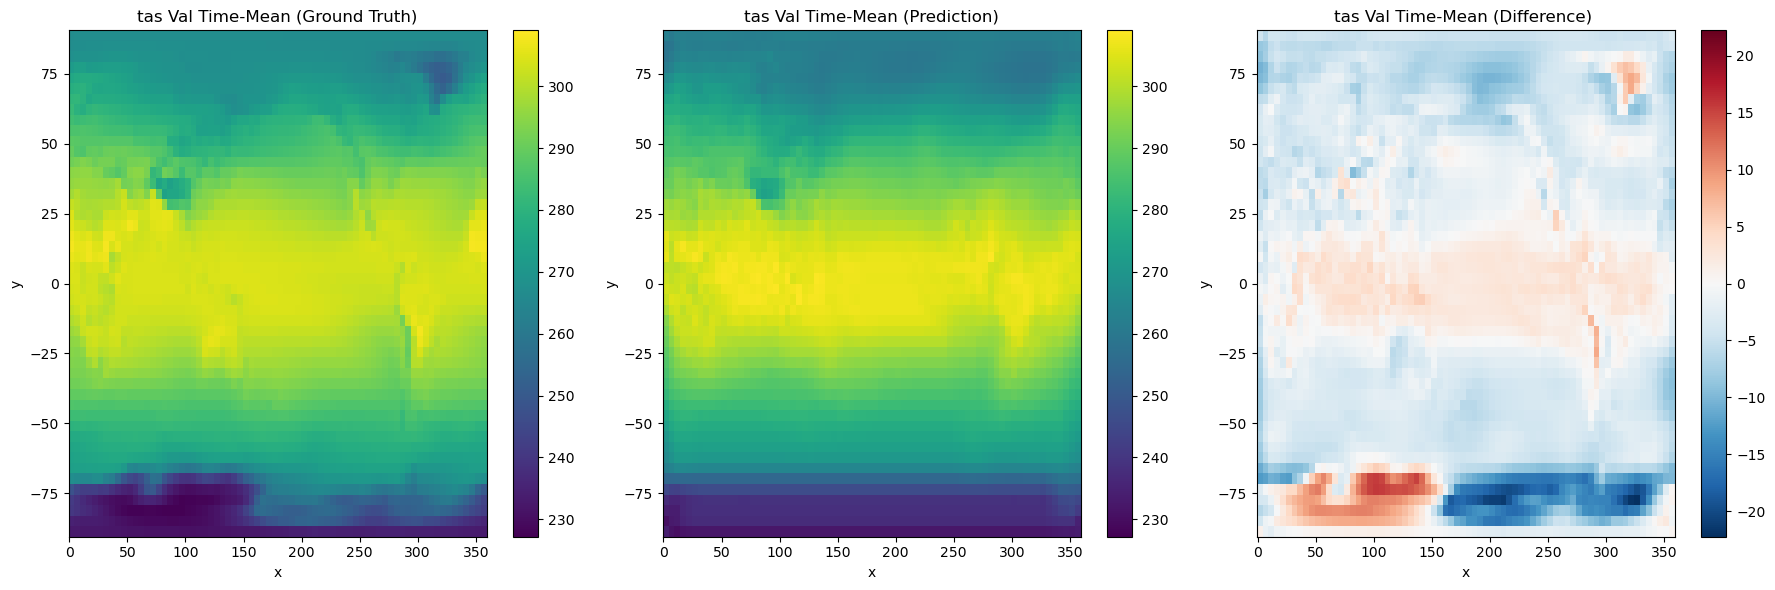

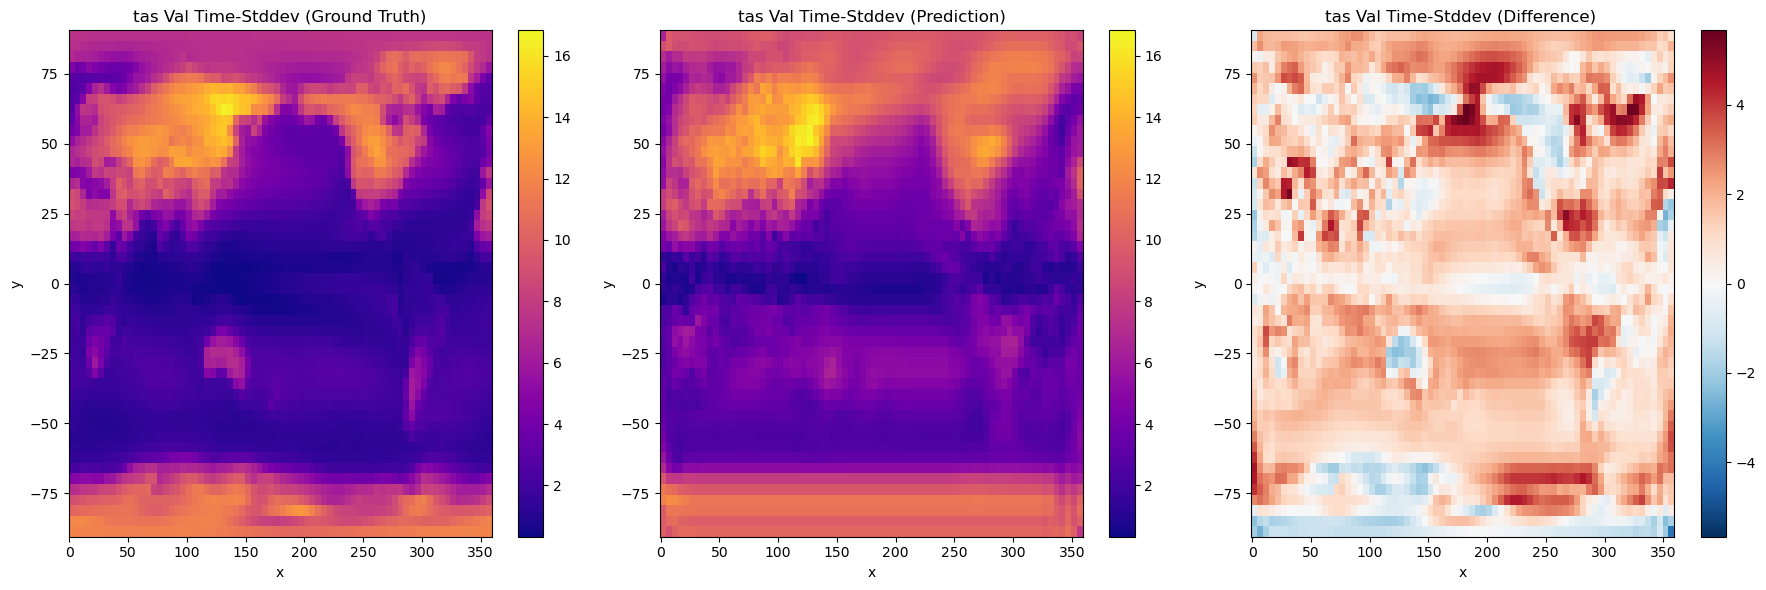

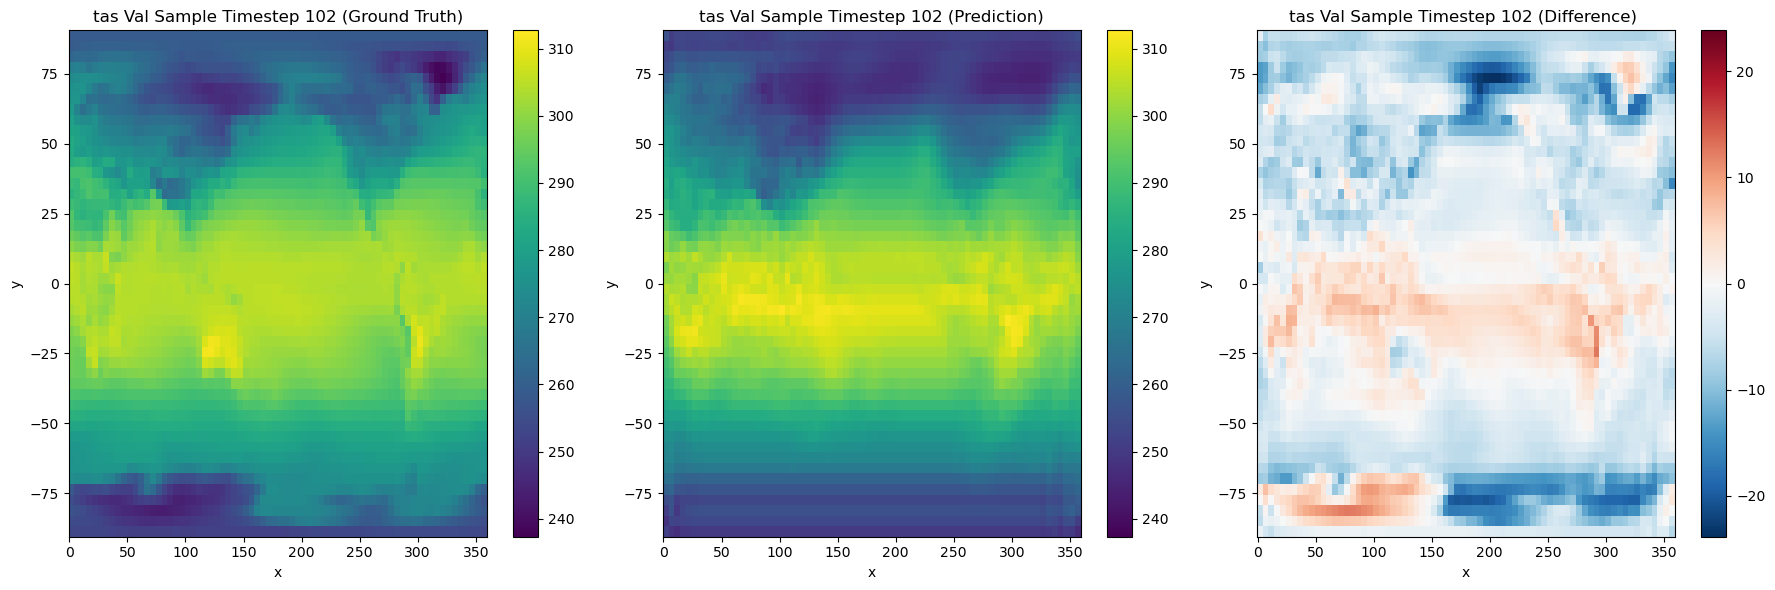

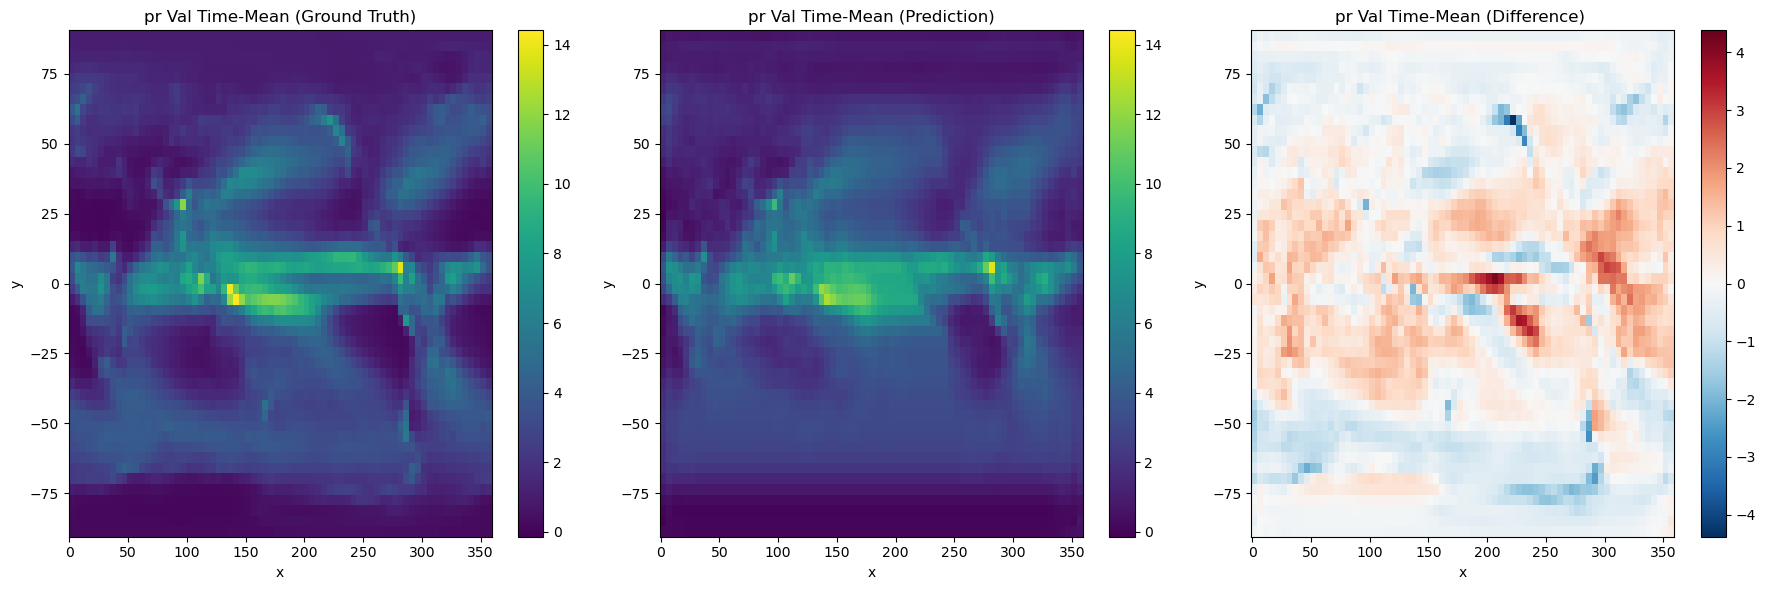

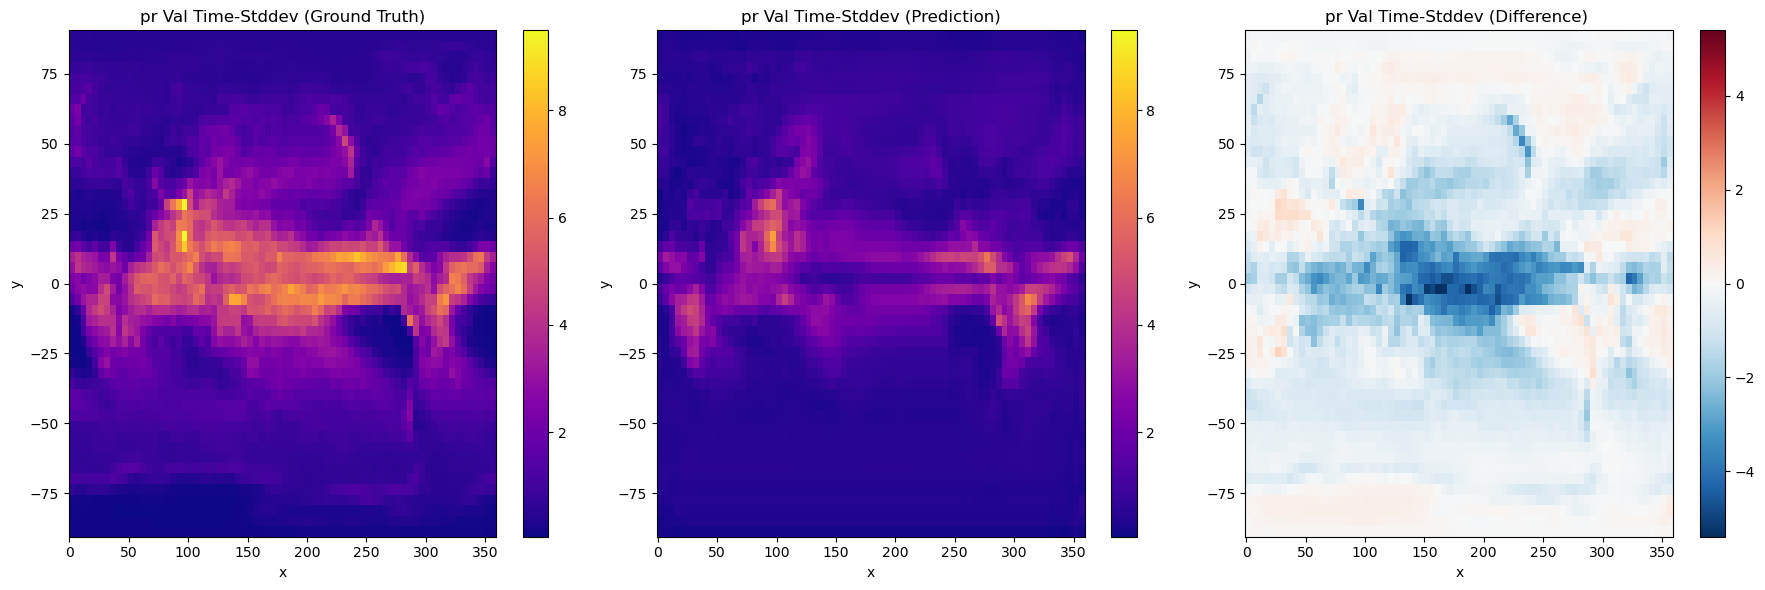

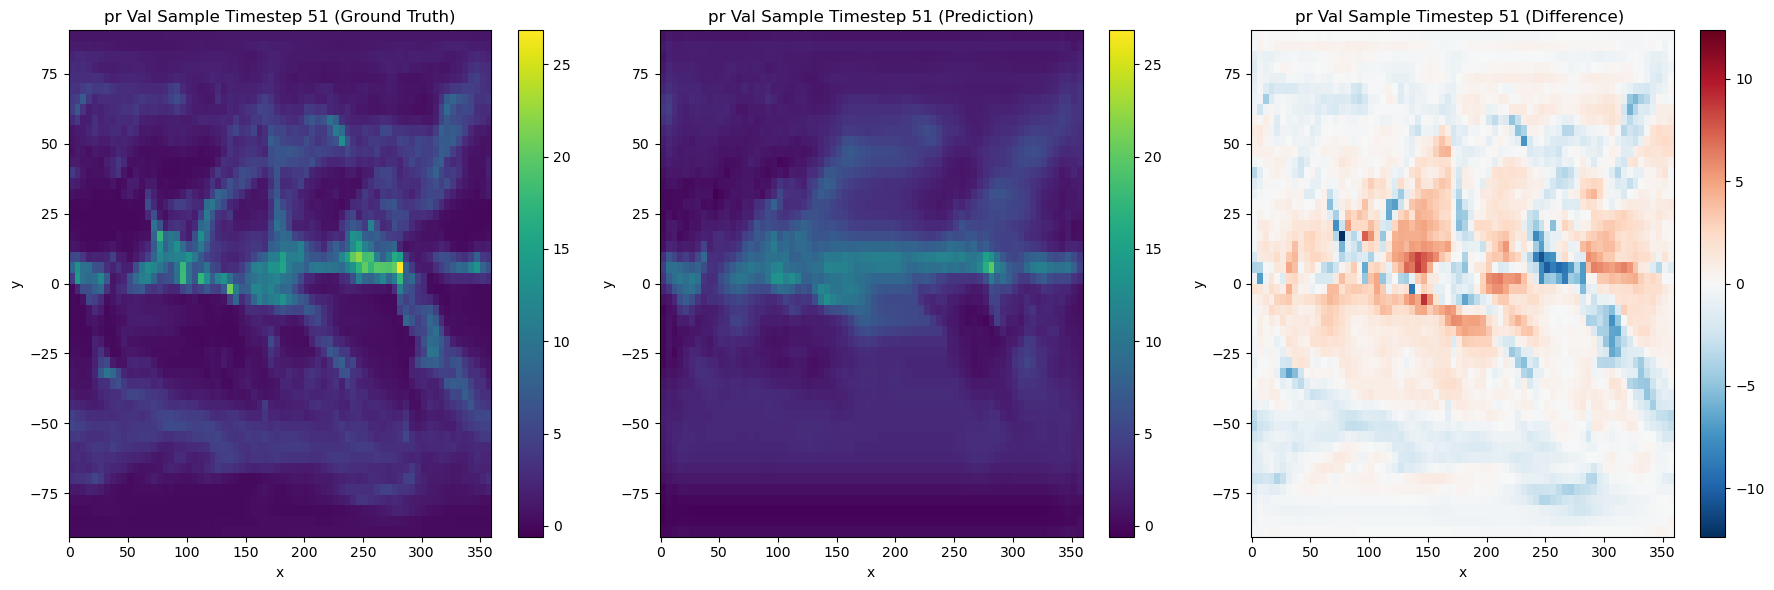

In [ ]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


## 🧪 Final Notes

This notebook is meant to serve as a **baseline template** — a starting point to help you get up and running quickly with the climate emulation challenge.

You are **not** required to stick to this exact setup. In fact, we **encourage** you to:

- 🔁 Build on top of the provided `DataModule`.
- 🧠 Use your own model architectures or training pipelines that you’re more comfortable with
- ⚗️ Experiment with ideas  
- 🥇 Compete creatively to climb the Kaggle leaderboard  
- 🙌 Most importantly: **have fun** and **learn as much as you can** along the way

This challenge simulates a real-world scientific problem, and there’s no single "correct" approach — so be curious, experiment boldly, and make it your own!
